# Proyecto Sprint 10

### Descripción del proyecto:

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba. 

Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

### Instrucciones a realizar:

Descarga y prepara los datos.  Explica el procedimiento.

Examina el equilibrio de clases. Entrena el modelo sin tener en cuenta el desequilibrio. Describe brevemente tus hallazgos.

Mejora la calidad del modelo. Asegúrate de utilizar al menos dos enfoques para corregir el desequilibrio de clases. Utiliza conjuntos de entrenamiento y validación para encontrar el mejor modelo y el mejor conjunto de parámetros. Entrena diferentes modelos en los conjuntos de entrenamiento y validación. Encuentra el mejor. Describe brevemente tus hallazgos.
Realiza la prueba final.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, roc_auc_score, classification_report,
    roc_curve, ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, roc_auc_score
)
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [21]:
data = pd.read_csv('C:/Users/gabri/OneDrive/TripleTen/Curso/Sprint 10/Churn.csv')
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


### 1) Preparación de datos y valores descriptivos

*Nota:* Para describir cómo es que estoy trabajando los datos, de manera breve, adjunto un descriptivo para seguir el hilo del análisis:

- Ofrezco una visualización del histograma del salario, para poder visualizar la distribución de los datos de dicha variable.

- También adjunto una distribución de la edad de los clientes, posteriormente convierto la edad en variable categórica (está tipificada por intervalos).

- Se convierte a variable categórica la variable ubicación.

- El sexo igual se convierte a variable categórica.


a)  **Distribución del salario**

El valor máximo del salario es: 199992.48
El valor mínimo del salario es: 11.58
De la misma forma, tenemos que el promedio salarial es: 100090.239881


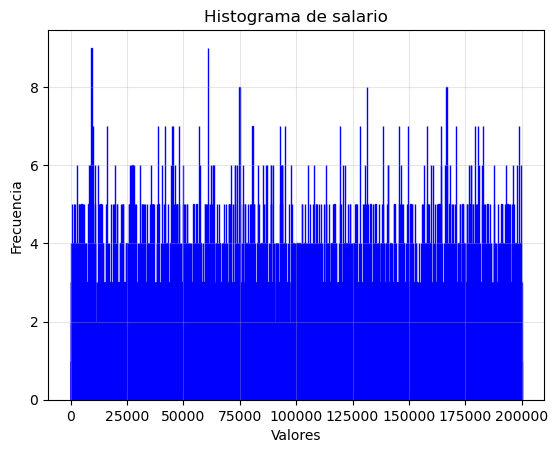

In [22]:
print('El valor máximo del salario es:', data['EstimatedSalary'].max())
print('El valor mínimo del salario es:', data['EstimatedSalary'].min())
print('De la misma forma, tenemos que el promedio salarial es:', data['EstimatedSalary'].mean())

#Voy a crear un histograma para ver la distribución de los salarios
plt.hist(data['EstimatedSalary'], bins= 5000, edgecolor = 'blue')
plt.title('Histograma de salario')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.show()

b) **Distribución de la edad de los clientes**

La edad máxima es: 92
La edad mínima en el DF es: 18
La edad promedio de los clientes: 38.9218


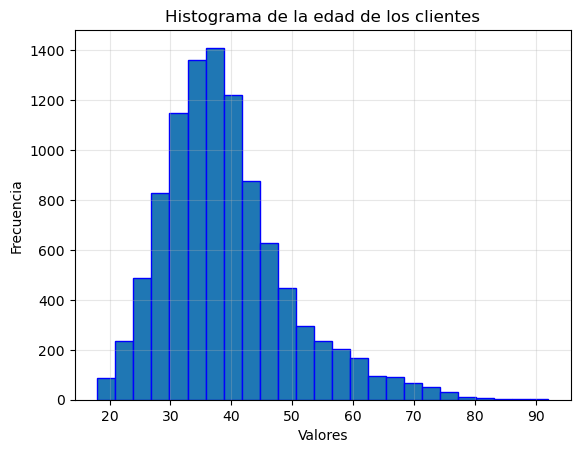

In [23]:
print('La edad máxima es:', data['Age'].max())
print('La edad mínima en el DF es:', data['Age'].min())
print('La edad promedio de los clientes:', data['Age'].mean())

#Creamos el gráfico para ver la distribución de los datos:
plt.hist(data['Age'], bins= 25, edgecolor = 'blue')
plt.title('Histograma de la edad de los clientes')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.show()



En este caso, tenemos una tendencia hacia la izquierda, en donde la edad en donde más se concentra la población de los clientes está en un intervalo de entre los 30 y 50 años. 

**En el siguiente snippet se convierte a variable categórica la variable edad en los siguientes intervalos:**

- De 18 a 30 años, el valor es 0.

- De 31 a 50 años, el valor es 1.

- De 51 a 92 años, el valor es 2.

In [24]:
# Categorizamos las variables creando otra columna categorizada por gruposS:

#Definir condiciones 
conditions = [
    data['Age'].between(18, 30),  
    data['Age'].between(31, 50), 
    data['Age'].between(51, 92)  
]

#Definir los valores de la variable
choices = [0, 1, 2]

# Creamos una columna AgeGroup
# Si algún valor de Age queda fuera de estos rangos, será tipificado con -1
data['AgeGroup'] = np.select(conditions, choices, default=-1)

data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,1
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,1
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0,1
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0,1
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1,1


c) **Converimos a variable categórica la ubicación**

In [25]:
#Vamos a ver los valores únicos antes de convertir a categóricas:
print('Para convertir a variables categóricas, en términos de  ubicación, tenemos los siguientes datos:', data['Geography'].unique())

dummies_geo = pd.get_dummies(data['Geography'], prefix='geo_dummy', drop_first=True) #Estoy usando drop_first para eliminar la primera categoría,
#en este caso France, para evitar multicolinealidad y optimizar el modelo desde el planteamiento.
data = pd.concat([data, dummies_geo], axis = 1)
print(data)

Para convertir a variables categóricas, en términos de  ubicación, tenemos los siguientes datos: ['France' 'Spain' 'Germany']
      RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000 

d) **Conversión de variable sexo a variable categórica**

In [26]:
dummies_sexo = pd.get_dummies(data['Gender'], prefix= 'sexo_dummy', drop_first=True)
data = pd.concat([data, dummies_sexo], axis=1)

In [27]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup,geo_dummy_Germany,geo_dummy_Spain,sexo_dummy_Male
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,1,False,False,False
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,1,False,True,False
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,1,False,False,False
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,1,False,False,False
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,1,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0,1,False,False,True
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0,1,False,False,True
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1,1,False,False,False
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1,1,True,False,True


### 2) Construcción del modelo por regresión logística:

La construcción de este modelo nos va a ayudar a saber la probabilidad de que los usuarios del banco se queden en calidad de clientes, o bien, tomen la desición de darse de baja. Para esto, se toman en cuenta las variables dentro del dataframe.


Coeficientes del modelo:
CreditScore: -0.0800
sexo_dummy_Male: -0.2728
Tenure: -0.0275
Balance: 0.1711
geo_dummy_Spain: 0.0311
geo_dummy_Germany: 0.3377
EstimatedSalary: 0.0272
AgeGroup: 0.6617
Intercepto: -1.5460

Exactitud: 80.90%
Precisión: 56.63%
Recall: 11.96%
F1 Score: 19.75%
AUC : 72.81%


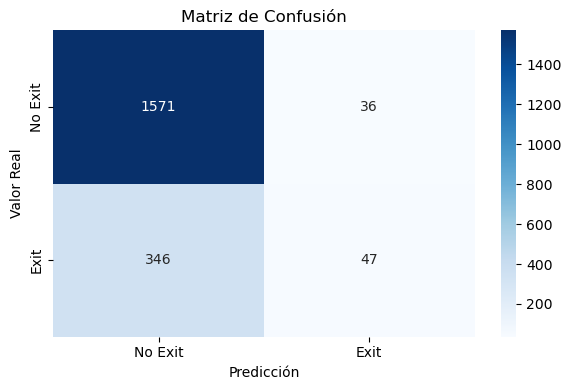

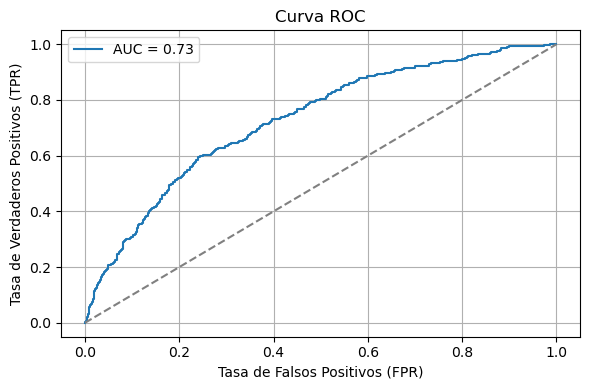

In [38]:
#Preparación de variables de interés X e Y
X = data[['CreditScore', 'sexo_dummy_Male', 'Tenure', 'Balance',
          'geo_dummy_Spain', 'geo_dummy_Germany',
          'EstimatedSalary', 'AgeGroup']]
Y = data['Exited']

# Limpieza de datos
X = X.fillna(X.mean(numeric_only=True))
if X['AgeGroup'].dtype == 'O' or X['AgeGroup'].isnull().any():
    X['AgeGroup'] = X['AgeGroup'].fillna(X['AgeGroup'].mode()[0])
Y = Y.fillna(Y.mode()[0])

columnas = X.columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División de datos
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Entrenamiento del modelo
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, Y_train)

# para los coeficientes
print("\nCoeficientes del modelo:")
for feature, coef in zip(columnas, modelo.coef_[0]):
    print(f"{feature}: {coef:.4f}")
print(f"Intercepto: {modelo.intercept_[0]:.4f}")

# La predicción
Y_pred = modelo.predict(X_test)
Y_prob = modelo.predict_proba(X_test)[:, 1]  # probabilidades para curva ROC

# Mis métricas
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
auc = roc_auc_score(Y_test, Y_prob)

print(f"\nExactitud: {accuracy:.2%}")
print(f"Precisión: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1:.2%}")
print(f"AUC : {auc:.2%}")

# para la matriz de confusión
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Exit", "Exit"],
            yticklabels=["No Exit", "Exit"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.tight_layout()
plt.show()

# Para la curva ROC
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Curva ROC")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### De acuerdo a los resultados obtenidos, tenemos que:

- A mayor puntaje en el crédito, tenemos una menor probabilidad de que el cliente de vaya.

- La variable de sexo nos indica que si hay una diferenciación entre ser hombre o mujer en términos de permanencia, es decir, que dentro de los clientes estudiados, los hombres tienen una mayor tendencia a quedarse, con respecto a las clientas.

- A mayor tiempo en calidad de cliente hay una probabilidad ligeramente menor de irse.

- **A mayor saldo, tenemos una mayor probabilidad de que el cliente se vaya**

- En términos de ubicación, también hay una relevancia según los datos, ya que las personas que viven en Alemania son mas propensos a abandonar el banco. Mientras que la gente que vive en españa tiene una menor probailidad, respecto a Alemania.


- El coeficiente del salario es positivo, entonces a mayor salario hay una probabilidad mayor de irse del banco.

- **También tenemos que entre más edad tiene un cliente, este tiene una mayor probabilidad de dejar de ser cliente.**

##### Sobre las métricas: 

Concretamente podemos decir que el modelo acierta en un 80.9% de las veces que predice si el cliente se va o se queda. Además, tenemos una presición el 56.6%. De los clientes que se fueron, el modelo predijo un 11.96% 

Ya por último, el modelo tiene una capacidad de separar bien si el cliente se va o se queda en un 72.81%.

Además tenemos que la exactitud está inflada porque el modelo no está balanceado y, por consiguiente, no tenemos un dato que refleje un buen desempeño del modelo.

### 3) Mejoramiento del modelo 

a) Vamos a reponderar las clases, balanceando el modelo.


Coeficientes del modelo:
CreditScore: -0.0810
sexo_dummy_Male: -0.2719
Tenure: -0.0318
Balance: 0.1786
geo_dummy_Spain: 0.0465
geo_dummy_Germany: 0.3419
EstimatedSalary: 0.0286
AgeGroup: 0.6546
Intercepto: -0.1924

Exactitud: 66.90%
Precisión: 32.78%
Recall: 65.14%
F1 Score: 43.61%
AUC : 72.76%


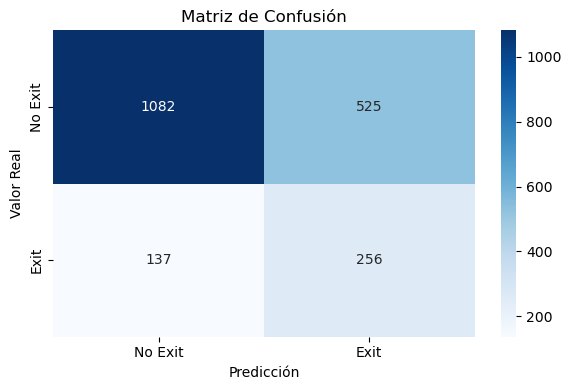

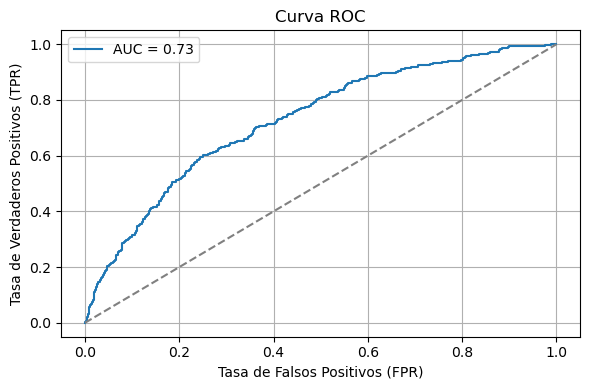

In [43]:
#Preparación de variables de interés X e Y
X = data[['CreditScore', 'sexo_dummy_Male', 'Tenure', 'Balance',
          'geo_dummy_Spain', 'geo_dummy_Germany',
          'EstimatedSalary', 'AgeGroup']]
Y = data['Exited']

# Limpieza de datos
X = X.fillna(X.mean(numeric_only=True))
if X['AgeGroup'].dtype == 'O' or X['AgeGroup'].isnull().any():
    X['AgeGroup'] = X['AgeGroup'].fillna(X['AgeGroup'].mode()[0])
Y = Y.fillna(Y.mode()[0])

columnas = X.columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División de datos
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Entrenamiento del modelo
modelo = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=12345, solver='liblinear' )
modelo.fit(X_train, Y_train)

# para los coeficientes
print("\nCoeficientes del modelo:")
for feature, coef in zip(columnas, modelo.coef_[0]):
    print(f"{feature}: {coef:.4f}")
print(f"Intercepto: {modelo.intercept_[0]:.4f}")

# La predicción
Y_pred = modelo.predict(X_test)
Y_prob = modelo.predict_proba(X_test)[:, 1]  # probabilidades para curva ROC

# Mis métricas
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
auc = roc_auc_score(Y_test, Y_prob)

print(f"\nExactitud: {accuracy:.2%}")
print(f"Precisión: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1:.2%}")
print(f"AUC : {auc:.2%}")

# para la matriz de confusión
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Exit", "Exit"],
            yticklabels=["No Exit", "Exit"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.tight_layout()
plt.show()

# Para la curva ROC
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Curva ROC")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Sobre las métricas correctivas:**

En este contexto, tenemos que el modelo, ya balanceado, nos da resultados más realista, no está inflada la exactitud. Así mismo, se declara una baja en la precisión del modelo de casi 24%. Pero obtenemos un muy buen porcentaje en la detección, de 11.96% al 65.14%, obtenemos un mejor valor de equilibrio F1. Y algo importante a notar es que la curva ROC es muy similar, lo que es bueno, porque se conserva la capacidad en términos discrimintativos de si se va o se queda el cliente.

En este segundo modelo aparte de balancearlo, le introduje más hiperparámetros, en aras de obtener mejores resultados.


b) Modelo combinado son técnica de sobremuestreo y ajuste de umbral de clasificación


Métricas por umbral:
   Umbral  Precisión  Recall     F1    AUC
0     0.1      0.207   1.000  0.342  0.721
1     0.2      0.229   0.973  0.371  0.721
2     0.3      0.245   0.959  0.390  0.721
3     0.4      0.284   0.816  0.422  0.721
4     0.5      0.344   0.627  0.445  0.721
5     0.6      0.400   0.431  0.415  0.721
6     0.7      0.467   0.274  0.345  0.721
7     0.8      0.543   0.107  0.178  0.721
8     0.9      0.667   0.010  0.019  0.721


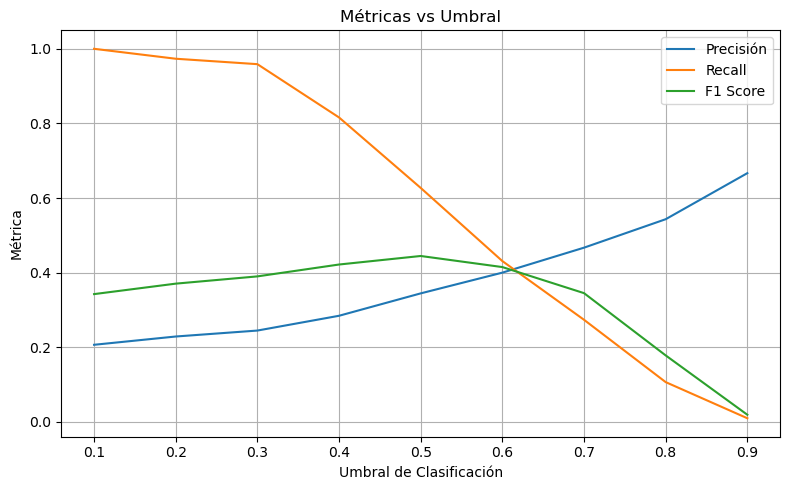


 Umbral óptimo según F1 score: 0.50

Evaluación final en conjunto de prueba:
Exactitud: 67.85%
Precisión: 33.42%
Recall: 64.12%
F1 Score: 43.94%
AUC: 72.59%

Matriz de Confusión:
[[1105  502]
 [ 141  252]]


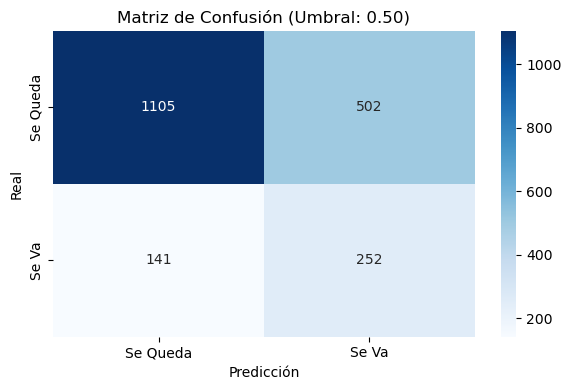

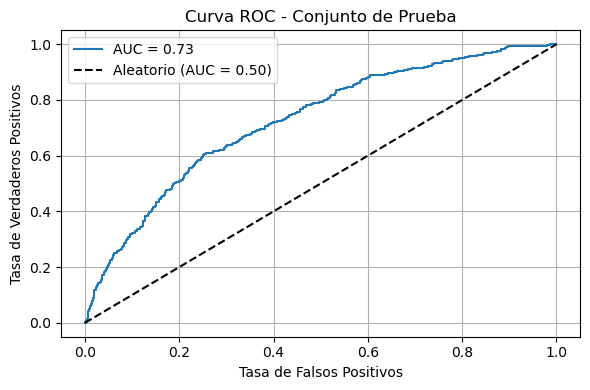

In [50]:
#Preparación de datos
X = data[['CreditScore', 'sexo_dummy_Male', 'Tenure', 'Balance',
          'geo_dummy_Spain', 'geo_dummy_Germany',
          'EstimatedSalary', 'AgeGroup']]
Y = data['Exited']

X = X.fillna(X.mean(numeric_only=True))
if X['AgeGroup'].dtype == 'O' or X['AgeGroup'].isnull().any():
    X['AgeGroup'] = X['AgeGroup'].fillna(X['AgeGroup'].mode()[0])
Y = Y.fillna(Y.mode()[0])

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)  # 60/20/20

smote = SMOTE(random_state=42)
X_train_sm, Y_train_sm = smote.fit_resample(X_train, Y_train)

# Construcción del modelo
modelo = LogisticRegression(max_iter=1000, random_state=12345, solver='liblinear')
modelo.fit(X_train_sm, Y_train_sm)

# Validación
Y_val_prob = modelo.predict_proba(X_val)[:, 1]

# Ajuste del umbral
umbrales = np.linspace(0.1, 0.9, 9)
metricas = []

for umbral in umbrales:
    Y_pred_umbral = (Y_val_prob >= umbral).astype(int)
    metricas.append({
        'Umbral': umbral,
        'Precisión': precision_score(Y_val, Y_pred_umbral),
        'Recall': recall_score(Y_val, Y_pred_umbral),
        'F1': f1_score(Y_val, Y_pred_umbral),
        'AUC': roc_auc_score(Y_val, Y_val_prob)
    })

df_metricas = pd.DataFrame(metricas)
print("\nMétricas por umbral:")
print(df_metricas.round(3))

# Anexo un gráfico que corresponde a las métricas
plt.figure(figsize=(8, 5))
plt.plot(df_metricas['Umbral'], df_metricas['Precisión'], label='Precisión')
plt.plot(df_metricas['Umbral'], df_metricas['Recall'], label='Recall')
plt.plot(df_metricas['Umbral'], df_metricas['F1'], label='F1 Score')
plt.xlabel("Umbral de Clasificación")
plt.ylabel("Métrica")
plt.title("Métricas vs Umbral")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Para la selección del umbral
mejor_umbral = df_metricas.loc[df_metricas['F1'].idxmax(), 'Umbral']
print(f"\n Umbral óptimo según F1 score: {mejor_umbral:.2f}")

# Prueba
Y_test_prob = modelo.predict_proba(X_test)[:, 1]
Y_test_pred = (Y_test_prob >= mejor_umbral).astype(int)

print("\nEvaluación final en conjunto de prueba:")
print(f"Exactitud: {accuracy_score(Y_test, Y_test_pred):.2%}")
print(f"Precisión: {precision_score(Y_test, Y_test_pred):.2%}")
print(f"Recall: {recall_score(Y_test, Y_test_pred):.2%}")
print(f"F1 Score: {f1_score(Y_test, Y_test_pred):.2%}")
print(f"AUC: {roc_auc_score(Y_test, Y_test_prob):.2%}")

# Matriz de Confusión
cm = confusion_matrix(Y_test, Y_test_pred)


print("\nMatriz de Confusión:")
print(cm)


plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Se Queda', 'Se Va'],
            yticklabels=['Se Queda', 'Se Va'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f"Matriz de Confusión (Umbral: {mejor_umbral:.2f})")
plt.tight_layout()
plt.show()


# Curva ROC
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_prob)


plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(Y_test, Y_test_prob):.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio (AUC = 0.50)')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - Conjunto de Prueba")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


En este inciso tenemo muy ligeras mejoras con respecto al modelo del inciso a), la curva ROC es prácticamente la misma, en resumidas cuentas, podemos decir que cualquiera de las 2 técnicas propuestas optimiza de manera similar el modelo.

En esta parte del análisis incluyo una gráfica, misma que se refiere a la variación de las métricas en función del umbral, se añade este elemento para poder estudiar con más facilidad la optimización del modelo.
